In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.50
    Uninstalling langchain-core-0.3

In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Define Agent

In [3]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  itinerary: str

In [41]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "meta-llama/llama-4-scout-17b-16e-instruct"
)


In [5]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my day trip."),
])

Define Agent Function

In [6]:
def process_inputs(state: PlannerState) -> PlannerState:
    """Collects user input for the city, interests, and duration of the trip."""
    print("Please enter the city you want to visit for your trip: ")
    city_input = input("Your Input: ")

    print(f"Please enter your interests for the trip to {city_input} (comma-separated): ")
    interests_input = input("Your Input: ")

    print("How many days will your trip last? (Enter a number): ")
    days_input = int(input("Your Input: "))

    return {
        **state,
        "city": city_input,
        "interests": [interest.strip() for interest in interests_input.split(",")],
        "days": days_input,
        "messages": state["messages"] + [
            HumanMessage(content=f"City: {city_input}"),
            HumanMessage(content=f"Interests: {interests_input}"),
            HumanMessage(content=f"Days: {days_input}"),
        ]
    }

def generate_itinerary(state: PlannerState) -> PlannerState:
    """Generates an itinerary based on user inputs."""
    print(f"Creating an itinerary for {state['city']} based on interests: {', '.join(state['interests'])}")

    response = llm.invoke(itinerary_prompt.format_messages(
        city=state["city"],
        interests=", ".join(state["interests"]),
        days=state["days"]
    ))

    print("\n📌 Final Itinerary:\n")
    print(response.content)

    return {
        **state,
        "itinerary": response.content,
        "messages": state["messages"] + [AIMessage(content=response.content)],
    }

def fetch_city_image(state: PlannerState) -> PlannerState:
    """Fetches an image of the city from the Unsplash API."""
    print(f"Fetching an image for {state['city']}...")

    url = f"https://api.unsplash.com/search/photos?query={state['city']}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url).json()

    image_url = response["results"][0]["urls"]["regular"] if response["results"] else None
    return {**state, "image_url": image_url}

def generate_maps_link(state: PlannerState) -> PlannerState:
    """Generates a Google Maps link for the city."""
    maps_link = f"https://www.google.com/maps/search/{state['city']}"
    print(f"Google Maps Link: {maps_link}")
    return {**state, "maps_link": maps_link}

def format_itinerary(state: PlannerState) -> PlannerState:
    """Formats the itinerary for better readability."""
    formatted_itinerary = markdown2.markdown(f"### 🗺️ Your Travel Itinerary\n\n{state['itinerary']}")
    return {**state, "itinerary": formatted_itinerary}


Create and Compile the Graph

In [7]:
workflow = StateGraph(PlannerState)

# Adding Nodes
workflow.add_node("process_inputs", process_inputs)
workflow.add_node("generate_itinerary", generate_itinerary)
workflow.add_node("fetch_city_image", fetch_city_image)
workflow.add_node("generate_maps_link", generate_maps_link)
workflow.add_node("format_itinerary", format_itinerary)

# Setting Entry Point
workflow.set_entry_point("process_inputs")

# Defining Edges (Workflow Steps)
workflow.add_edge("process_inputs", "generate_itinerary")
workflow.add_edge("generate_itinerary", "fetch_city_image")
workflow.add_edge("fetch_city_image", "generate_maps_link")
workflow.add_edge("generate_maps_link", "format_itinerary")
workflow.add_edge("format_itinerary", END)

# Compile the Workflow
app = workflow.compile()


Display the graph structure

In [8]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


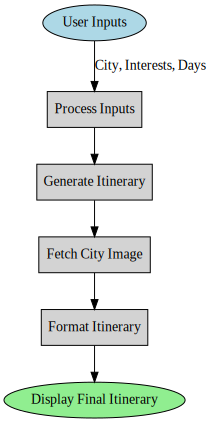

In [9]:
from graphviz import Digraph

def display_workflow_graph():
    dot = Digraph(comment="AI Travel Planner Workflow")

    # Define Nodes
    dot.node("A", "User Inputs", shape="oval", style="filled", fillcolor="lightblue")
    dot.node("B", "Process Inputs", shape="box", style="filled", fillcolor="lightgray")
    dot.node("C", "Generate Itinerary", shape="box", style="filled", fillcolor="lightgray")
    dot.node("D", "Fetch City Image", shape="box", style="filled", fillcolor="lightgray")
    dot.node("E", "Format Itinerary", shape="box", style="filled", fillcolor="lightgray")
    dot.node("F", "Display Final Itinerary", shape="oval", style="filled", fillcolor="lightgreen")

    # Define Edges (Connections)
    dot.edge("A", "B", label="City, Interests, Days")
    dot.edge("B", "C")
    dot.edge("C", "D")
    dot.edge("D", "E")
    dot.edge("E", "F")

    # Render Graph
    return dot

# Display the graph
display_workflow_graph()


Define the function thats runs the graph

In [29]:
def travel_planner(user_request: str):
    print(f"Initial Request: {user_request}\n")

    # Initial empty state
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "interests": [],
        "days": 1,
        "itinerary": "",
    }

    # Collect city input
    city = input("Please enter the city you want to visit for your trip: \nYour Input: ").strip()
    state["city"] = city
    state["messages"].append(HumanMessage(content=city))

    # Collect interests
    interests_str = input(f"Please enter your interests for the trip to {city} (comma-separated): \nYour Input: ")
    interests = [i.strip() for i in interests_str.split(",") if i.strip()]
    state["interests"] = interests
    state["messages"].append(HumanMessage(content=", ".join(interests)))

    # Collect number of days
    try:
        days = int(input("How many days will your trip last? (Enter a number): \nYour Input: "))
    except ValueError:
        print("Invalid input. Defaulting to 1 day.")
        days = 1
    state["days"] = days

    print(f"\nCreating an itinerary for {city} based on interests: {', '.join(interests)}")

    # Generate itinerary

    itinerary = generate_itinerary(state)
    print("\n--- Your Itinerary ---")
    print(itinerary)



In [30]:
user_request = "I want to plan a trip"
travel_planner(user_request)

Initial Request: I want to plan a trip

Please enter the city you want to visit for your trip: 
Your Input: Bangalore
Please enter your interests for the trip to Bangalore (comma-separated): 
Your Input: Kormangala
How many days will your trip last? (Enter a number): 
Your Input: 2

Creating an itinerary for Bangalore based on interests: Kormangala
Creating an itinerary for Bangalore based on interests: Kormangala

📌 Final Itinerary:

For a day trip to Koramangala, Bangalore, here's a brief itinerary based on popular interests:

* 9:00 AM - 10:00 AM: Start the day with breakfast at one of Koramangala's popular cafes, such as The Hole in the Wall or Third Wave Coffee Roasters.
* 10:00 AM - 12:00 PM: Visit the Koramangala Indoor Stadium or the St. John's Auditorium to catch a local event or exhibition.
* 12:00 PM - 1:30 PM: Explore the Forum Mall or the Sony World Signal for shopping and dining options.
* 2:00 PM - 4:00 PM: Relax at the nearby HSR Layout Lake or take a stroll around the 

In [32]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00


In [33]:
!pip install markdown2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.7 MB/s eta 0:00:00


In [3]:
!pip install gradio langchain langchain_groq markdown2 folium pdfkit
!sudo apt install wkhtmltopdf  # for pdfkit to work


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon geoclue-2.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas iio-sensor-proxy
  libavahi-core7 libavahi-glib1 libdaemon0 libevdev2 libfontenc1
  libgudev-1.0-0

In [7]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 22.5 MB/s eta 0:00:00


In [15]:
import gradio as gr
import requests
import json
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
import markdown2

# API Key for City Images (Replace with your Unsplash key)
UNSPLASH_ACCESS_KEY = "yAGzVAEKW76ftKphmGI8B6jCGv9gkA2VUNQXB71a8HM"

class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "Conversation history"]
    city: str
    interests: List[str]
    days: int
    itinerary: str

# Define LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="meta-llama/llama-4-scout-17b-16e-instruct"
)

# Improved Itinerary Prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a smart travel planner. Create a {days}-day itinerary for {city} based on {interests}. "
               "Consider weather, budget, and must-see places. Use short bullet points."),
    ("human", "Generate my itinerary."),
])

# Fetch city image from Unsplash
def get_city_image(city):
    url = f"https://api.unsplash.com/search/photos?query={city}&client_id={UNSPLASH_ACCESS_KEY}"
    response = requests.get(url).json()
    if response["results"]:
        return response["results"][0]["urls"]["regular"]
    return None

# Process user inputs
def input_city(city: str, state: PlannerState) -> PlannerState:
    return {**state, "city": city, "messages": state['messages'] + [HumanMessage(content=city)]}

def input_interests(interests: List[str], state: PlannerState) -> PlannerState:
    return {**state, "interests": interests, "messages": state['messages'] + [HumanMessage(content=", ".join(interests))]}

def input_days(days: int, state: PlannerState) -> PlannerState:
    return {**state, "days": days}

# Generate the itinerary
def create_itinerary(state: PlannerState) -> str:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], interests=", ".join(state['interests']), days=state['days']))
    state["itinerary"] = response.content
    state["messages"] += [AIMessage(content=response.content)]
    return response.content

# Convert itinerary to Markdown for better formatting
def format_itinerary(itinerary: str) -> str:
    return markdown2.markdown(f"### Your Travel Itinerary 🗺️\n{itinerary}")

# Generate Google Maps search link
def generate_maps_link(city):
    return f"[📍 Explore {city} on Google Maps](https://www.google.com/maps/search/{city})"

# Main function
def travel_planner(city: str, interests: List[str], days: int):
    state = {
        "messages": [],
        "city": "",
        "interests": [],
        "days": 1,
        "itinerary": "",
    }

    # Process inputs
    state = input_city(city, state)
    state = input_interests(interests, state)
    state = input_days(days, state)

    # Generate itinerary
    itinerary = create_itinerary(state)
    formatted_itinerary = format_itinerary(itinerary)

    # Fetch city image
    city_image = get_city_image(city)

    # Google Maps link
    maps_link = generate_maps_link(city)


    return formatted_itinerary, city_image, maps_link,

# Gradio Interface with Improved UI
interface = gr.Interface(
    fn=travel_planner,
    inputs=[
        gr.Textbox(label="Enter City"),
        gr.CheckboxGroup(["Museums", "Beaches", "Food", "Music", "Hiking","Clubs","Hotels"], label="Select Your Interests"),
        gr.Slider(minimum=1, maximum=7, step=1, label="Trip Duration (Days)"),
    ],
    outputs=[
        gr.Markdown(label="Generated Itinerary"),
        gr.Image(label="City Image"),
        gr.Markdown(label="Google Maps Link"),
    ],
   title = "🌍 AI Travel Maestro",
description = "Plan personalized travel itineraries with the power of AI.",
theme = "dark",
css = """
body {
    background-color: #121212;
    color: #FFFFFF;
    font-family: 'Segoe UI', sans-serif;
}

.gradio-container {
    background-color: #1E1E1E;
    border-radius: 12px;
    padding: 20px;
    box-shadow: 0 0 12px rgba(0, 0, 0, 0.3);
}

input, select, textarea {
    border: 1.5px solid #555555;
    background-color: #2C2C2C;
    color: #FFFFFF;
    border-radius: 8px;
    padding: 10px;
    font-size: 14px;
}

label, h1, h2, h3, p {
    color: #FFFFFF;
}

.output {
    background-color: #1E1E1E;
    color: #FFFFFF;
    border: 1.5px solid #333333;
    border-radius: 10px;
    padding: 12px;
}

button {
    background-color: #FF5722;
    color: #FFFFFF;
    border-radius: 10px;
    padding: 10px 16px;
    font-size: 16px;
    border: none;
    cursor: pointer;
    transition: background-color 0.2s ease;
}

button:hover {
    background-color: #E64A19;
}

input[type="checkbox"] {
    accent-color: #FF5722;
}

.slider .handle {
    background-color: #FF5722;
}
"""


)

interface.launch()


/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1115: UserWarning: Cannot load dark. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/dark (Request ID: Root=1-67f7effd-79d34ac425b22d053b80cbf8;ecb2bd97-ae1c-44ed-a619-47c70c556d38)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://72a87393b716359626.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
